In [1]:
import pandas as pd
from dateutil.parser import parse 
import datetime
import numpy as np
import pylab as pl
from sympy import *

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


## 导入并预处理数据

分析wifi每天的变化，可知在凌晨4点是安检，航班以及wifi连接数为0，因此将其作为分界点

In [3]:
def imp_dat():
	departure=pd.read_csv("E:\\data_learn\\tianchi_stround\\da2\\airport_gz_departure_chusai_2ndround.csv")
	flights=pd.read_csv("E:\\data_learn\\tianchi_stround\\da2\\airport_gz_flights_chusai_2ndround.csv")
	gates=pd.read_csv("E:\\data_learn\\tianchi_stround\\da2\\airport_gz_gates.csv")
	security_check=pd.read_csv("E:\\data_learn\\tianchi_stround\\da2\\airport_gz_security_check_chusai_2ndround.csv")
	wifi_records=pd.read_csv("E:\\data_learn\\tianchi_stround\\da2\\WIFI_AP_Passenger_Records_chusai_2ndround.csv")
	return departure,flights,gates,security_check,wifi_records
# 将wifi连接上10分钟内平均
def mean_wifi(wifi_records):
	rlines=wifi_records['timeStamp'].values
	timeTen=[]
	timeStr=[]
	for i in rlines:
		timeTen.append(int(i[8:16].replace('-',''))/10*10)
		timeStr.append(i[:10])
	wifi_records['timeTen']=timeTen
	wifi_records['timeStr']=timeStr
	dfwftime=wifi_records.groupby(['WIFIAPTag','timeTen','timeStr'])
	dftenMean=dfwftime['passengerCount'].mean().reset_index()
	timeTen_str=dftenMean['timeTen'].values.astype(str)
	timeTen_str4=[]
	for i in timeTen_str:
			timeTen_str4.append(i[2:])
	dftenMean['timeTen_str']=timeTen_str
	dftenMean['timeTen_str4']=timeTen_str4
	slice10min=[]
	dftimeStr=dftenMean['timeStr'].values
	dftimeTen_str4=dftenMean['timeTen_str4'].values
	for i in xrange(dftimeStr.shape[0]):
		slice10min.append(dftimeStr[i]+'-'+dftimeTen_str4[i][:2]+'-'+dftimeTen_str4[i][2])
	dftenMean['slice10min']=slice10min
	#### delete the surperfluous data and show the "E1-1A-1<E1-1-01> "data
	wifi_all=dftenMean.drop(['timeTen','timeStr','timeTen_str','timeTen_str4'],axis=1)
	#wifi_all['timeTen_str4']=wifi_all['timeTen_str4'].astype(int)
	### 查看不同点的wifi数量
	df=wifi_all.groupby(['WIFIAPTag','slice10min'])
	rse=df.passengerCount.sum()
	wifi_all_split=rse.unstack().T
	return wifi_all_split
# 按天将wifi连接数分开
def getWIFIday11_24(wifi_all_split):    
    wifi_day=[]
    wifi_dayt=[]
    for i in range(10,26):
        tmp=[a  for a in wifi_all_split.index if a>='2016-09-'+str(i)+'-04-0' and a<='2016-09-'+str(i+1)+'-04-0']
        tmpt=[a  for a in wifi_all_split.index if a<='2016-09-'+str(i)+'-17-5' and a>='2016-09-'+str(i)+'-15-0']
        wifi_day.append(wifi_all_split.ix[tmp,:])
        wifi_dayt.append(wifi_all_split.ix[tmpt,:])
    return wifi_day,wifi_dayt

In [4]:
departure,flights,gates,security_check,wifi_records=imp_dat()
wifi_all_split=mean_wifi(wifi_records)
wifi_day,wifi_dayt=getWIFIday11_24(wifi_all_split)

In [223]:
# 合并航班与登机口区域
def getFla_gat(flights,gates):
	scheduled_flt=[parse(a)+datetime.timedelta(hours=8)  if type(a)==str else 0 for a in flights['scheduled_flt_time'].values]
	actual_flt=[parse(a)+datetime.timedelta(hours=8) if type(a)==str else 0  for a in flights['actual_flt_time'].values]
	flights['scheduled_flt'],flights['acutal_flt']=scheduled_flt,actual_flt

	flight_gate=pd.merge(flights,gates,on='BGATE_ID',how='left')
	oneDay_time=[str(a)[11:19] for a in flight_gate['scheduled_flt'].values]
	flight_gate['timeInDay']=oneDay_time

	late_timeAll=[]
	for i in range(flight_gate.shape[0]):
		if flight_gate.ix[i,5]!=0:
			late_timeAll.append(round((flight_gate.ix[i,5]-flight_gate.ix[i,4]).total_seconds(),0)/60)
		else:
			late_timeAll.append(-1)    
	flight_gate['late_time/min']=late_timeAll
	id_flt=[]
	for a in flight_gate.ix[:,['scheduled_flt','BGATE_ID']].astype(str).values:
		id_flt.append(a[0][-8:]+'_'+a[1])
	flight_gate['id_flt']=id_flt
	tmp=flight_gate
	del tmp['scheduled_flt_time']
	del tmp['actual_flt_time']
	return tmp
def separate_flight(flight_gate):
    all_=[]
    plane_fight_dic=[]
    for i in xrange(10,26):
        logi=[flight_gate.ix[a,'scheduled_flt']>=datetime.datetime(2016,9,i,4,0) and flight_gate.ix[a,'scheduled_flt']<datetime.datetime(2016,9,i+1,4,0)
              for a in xrange(flight_gate.shape[0])]
        ftmp=flight_gate[logi]
        tmp_dic={}
        for i in ftmp.ix[:,['flight_ID','id_flt']].values:
            tmp_dic[i[1]]=tmp_dic.get(i[1],[])+[i[0]]
        tmp_set=[]
        for i in ftmp['id_flt'].values:
            tmp_set.append(tmp_dic[i])
        ftmp['flt_set']=tmp_set
        ftmp['area_gate']=(ftmp['BGATE_AREA']+ftmp['BGATE_ID']).values
        all_.append(ftmp)
        plane_fight_dic.append(tmp_dic)        
    return all_,plane_fight_dic

In [9]:
flight_gate=getFla_gat(flights,gates)
fl_gt,plane_flight_dic=separate_flight(flight_gate)

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# res_new 为安检数，航班的合并表
res=np.load('res_new.npy')

''' 合并得到列为：id_flt	0	BGATE_ID	scheduled_flt	acutal_flt	BGATE_AREA	timeInDay	late_time/min	area_gate	id_concat的表
其中0表示此机型（非航班）对应所有的安检人数，id_concat为此机型对应的航班
'''
def fli_gat_count():
    n=len(res[0])
    all_=[]
    for i in xrange(n):
        res_cum=res[0][i].groupby(['secTime','id_flt']).size().unstack().resample('10T').sum().fillna(0).cumsum().max().reset_index()
        tmp_count=pd.merge(res_cum,fl_gt[i],how='right',on='id_flt')
        del tmp_count['flight_ID']
        tm=[]            
        for  ivs in tmp_count['flt_set'].values:
            s_=''
            for si in ivs:
                s_=s_+'_'+si             
            tm.append(s_)
        tmp_count['id_concat']=tm
        del tmp_count['flt_set']
        tmp_count=tmp_count.drop_duplicates()
        all_.append(tmp_count)
    return all_
fl_count=fli_gat_count()

##  建立模型

假设 每个机型对该wifi点影响数为起飞前3小时，总人数如果为N,那前3小时每10分钟的wifi比例为a_i(i=1,2,...,18).如果延期，那么延期的时间段内wifi比例一直为a_18，即最后一个比例值。将该候车厅所有机型对应的人数相加，与实际wifi数对应;最后，使用简单线性回归求取参数a_i.

### 每个机型对全天wifi_count的影响函数

In [375]:
passAr=np.array(getpassAr())*15

In [376]:
passAr

array([15*a_0, 15*a_1, 15*a_2, 15*a_3, 15*a_4, 15*a_5, 15*a_6, 15*a_7,
       15*a_8, 15*a_9, 15*a_10, 15*a_11, 15*a_12, 15*a_13, 15*a_14,
       15*a_15, 15*a_16, 15*a_17, 15*a_18, 15*a_19, 15*a_20, 15*a_21,
       15*a_22, 15*a_23, 15*a_24], dtype=object)

In [384]:
n=30;parN=25;rN=19;n_last=1;
#np.array([0]*(n-parN)+list(passAr[:rN])+list(passAr[rN])*n_last+list(passAr[-6:])+(144-n-n_last)*[0])
passAr[rN]

15*a_19

In [400]:
# N为该航班总人数
from dateutil.parser import parse
parN=25# 参数个数
def getpassCount(sctN):
    sct,act,N=sctN
    passAr=np.array(getpassAr())*N
    n=(sct-parse(str(sct.date())+' 04:00:00')).seconds/600
    n_last=(act-sct).seconds/600
    rN=parN-6
    if n<=parN and (n+n_last)<=144:
        return np.array(list(passAr[-n:-6])+[passAr[-6]]*n_last+list(passAr[-6:])*(144-n-n_last-6)*[0])
    elif n<=parN and (n+n_last)>150:
        return np.array(list(passAr[-n:-6])+[passAr[rN]]*(150-n))
    elif  n<=parN and (n+n_last)<150 and (n+n_last)>144:
        return np.array(list(passAr[-n:-6])+[passAr[rN]]*n_last+list(passAr[rN:(rN-n-n_last+150)]))
    elif n>parN and (n+n_last)<=144:
        return np.array([0]*(n-parN)+list(passAr[:rN])+[passAr[rN]]*n_last+list(passAr[-6:])+(144-n-n_last)*[0])
    elif n>parN and (n+n_last)>150:
        return np.array([0]*(n-parN)+list(passAr[:rN])+[passAr[rN]]*(150-n))
    elif n>parN and (n+n_last)<150 and (n+n_last)>144:
        return np.array([0]*(n-parN)+list(passAr[:rN])+[passAr[-6]]*(n_last)+list(passAr[rN:(rN-n-n_last+150)]))

### 一个入口所有航班wifi_count

In [401]:
def allofgate(N=1,gate_id='A01'): 
    #入口所有航班列表[]
    #allflights=[[sct,N],[sct,N],..,[sct,N]]
    fl_counN=fl_count[N]
    gatN=fl_counN[fl_counN['BGATE_ID']==gate_id].ix[:,['scheduled_flt','acutal_flt',0]].values
    n=len(gatN)
    all_=getpassCount(gatN[0])
    for i in xrange(1,n):
        try:
            all_=all_+getpassCount(gatN[i])
        except:
            print i
    return all_

In [402]:
fl_counNall=fl_count[0]
for i in range(1,len(fl_count)):
    try:
        tmp=fl_count[i]
        tmp['day']=[a[0:10] for a in fl_count[i]['scheduled_flt'].astype(str)]
        fl_counNall=fl_counNall.append(tmp)
    except:
        print i

fl_gb=fl_counNall.groupby(['BGATE_ID','day']).size().unstack().fillna(0)

fl_counNall.fillna(0,inplace=True)
gate_nan=fl_counNall[fl_counNall['BGATE_ID']==0]

#fl_counNall.groupby(['BGATE_ID','day']).size().unstack().fillna(0).head(15)

### 一个区域对应的wifi点

In [403]:
def getwifiArea():
    wifiTag=wifi_day[1].columns
    wi_dic={}
    for a in wifiTag:
        b=a[:2]
        wi_dic[b]=wi_dic.get(b,[])+[a]
    return wi_dic
wi_dic=getwifiArea()

In [404]:
### 定义起飞前18个10分钟内数量参数
from sympy import *
parN=25# 定义的参数个数
def getpassAr():
    parabc=[]
    for i in range(parN):
        parabc.append('a_'+str(i))
    passAr=symbols(parabc)
    return passAr
parabc=getpassAr()
def getFactor(spy,parms=parabc):
    if type(spy)==int or type(spy)==float or type(spy)==str:
        return np.array([0]*parN)
    if spy.is_Add is False:
        tmp=[]
        for j in parms:
            tmp.append(int(spy.coeff(j)))
        return np.array(tmp)    
    args=spy.args
    num_list=np.array([0]*parN)
    for i in args:
        tmp=[]
        for j in parms:
            tmp.append(int(i.coeff(j)))
        num_list=num_list+np.array(tmp)        
    return np.array(num_list)
def factorMatrix(p1):
    tmp=[]
    for i in p1:
        try:
            tmp.append(getFactor(i))
        except:
            print i
    return np.array(tmp)   

### 线性回归分析

#### 前N天所有数据

In [405]:
x_list,y_list=[],[]
for n in range(1,15):
    x=factorMatrix(allofgate(N=n,gate_id='A101'))
    y=wifi_day[n].ix[:,'E1-3A<E1-3-01>'].values[:-1]
    x,y=x[:60],y[:60]        
    x_list,y_list=x_list+list(x),y_list+list(y)

1


<IPython.core.display.Javascript object>


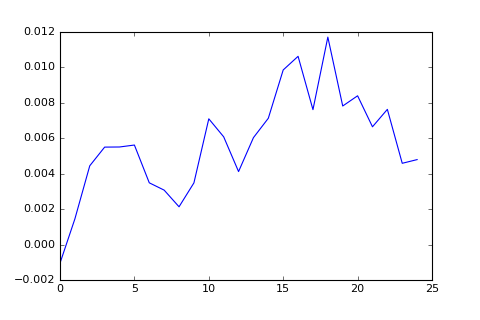

In [407]:
from sklearn.linear_model import LinearRegression
rg=LinearRegression()
rg.fit(x_list,y_list)
pl.plot(rg.coef_)

### 筛选有意义的wifi数